In [80]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor

Importing the data using read_csv


In [37]:
statistics = pd.read_csv("..\\data\\raw\\mlb_elo_latest.csv")

Looking at some summary statistics. It looks like a lot of these statistics are relevant/useful here. I'm not exactly sure how elo is being calculated. After further research, it looks like it is similar to how elo is calculated in online games. Teams gain some elo for winning and lose some for losing where the amount won or loss is dependant on previous beliefs about how good each team is. Another slightly confusing field is the pitcher rGS. This stands for rolling game score, it predicts how well the pitcher will pitch by more heavily weighting previous performances. There are some things that we need to be careful of here. We are trying to predict the score, so it would be bad to use any of the post fields. This is because these fields will contain information from the event that we are trying to predict

In [38]:
statistics.describe()

,season,neutral,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
count,936.0,936.000000,936.000000,936.000000,936.000000,936.000000,916.000000,916.000000,936.000000,936.000000,924.000000,921.000000,924.000000,921.000000,936.000000,936.000000,916.000000,916.000000,916.000000,916.000000
mean,2020.0,0.021368,1507.167394,1505.270523,0.536018,0.463982,1506.216790,1504.505931,1507.109309,1505.552651,50.883912,50.639906,-0.890154,-1.920995,0.517600,0.482400,1506.264022,1504.669022,4.727074,4.532751
std,0.0,0.144683,37.473348,36.855056,0.079047,0.079047,37.131832,36.536670,41.257392,40.919978,4.406138,4.294294,18.453987,18.088519,0.089678,0.089678,40.945223,40.617749,3.181189,3.360005
min,2020.0,0.000000,1418.777044,1414.802235,0.355959,0.287908,1418.777044,1414.802235,1413.496963,1410.151995,40.570121,40.764199,-56.236406,-54.874906,0.240866,0.269146,1413.496963,1410.151995,0.000000,0.000000
25%,2020.0,0.000000,1478.582537,1478.328034,0.479185,0.402753,1478.221433,1477.836846,1477.473506,1475.369699,47.577242,47.519515,-13.792722,-14.548848,0.453557,0.415126,1477.062239,1473.991168,2.000000,2.000000
50%,2020.0,0.000000,1504.602117,1503.348394,0.539433,0.460567,1503.384189,1502.749035,1510.291418,1509.888161,49.877774,49.734595,-2.595323,-2.791235,0.515774,0.484226,1509.677311,1508.753898,4.000000,4.000000
75%,2020.0,0.000000,1534.749151,1533.930055,0.597247,0.520815,1533.224107,1532.323075,1534.104545,1533.945041,53.651496,53.038906,10.553853,8.689707,0.584874,0.546443,1533.760375,1532.509885,6.000000,6.000000
max,2020.0,1.000000,1598.290926,1598.290926,0.712092,0.644041,1598.290926,1592.084018,1606.065971,1606.065971,66.751055,67.188358,58.796720,61.299547,0.730854,0.759134,1606.065971,1601.340435,29.000000,23.000000


In [39]:
statistics.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2020-10-10,2020,1,d,LAD,SDP,1598.290926,1525.832831,0.635558,0.364442,...,NaN,NaN,NaN,NaN,0.620261,0.379739,NaN,NaN,NaN,NaN
1,2020-10-10,2020,1,d,ATL,FLA,1543.508397,1482.006574,0.615867,0.384133,...,NaN,NaN,NaN,NaN,0.608742,0.391258,NaN,NaN,NaN,NaN
2,2020-10-09,2020,1,d,SDP,LAD,1525.832831,1598.290926,0.364442,0.635558,...,NaN,NaN,NaN,NaN,0.379739,0.620261,NaN,NaN,NaN,NaN
3,2020-10-09,2020,1,d,TBD,NYY,1566.075394,1557.931446,0.515622,0.484378,...,NaN,NaN,NaN,NaN,0.507634,0.492366,NaN,NaN,NaN,NaN
4,2020-10-09,2020,1,d,OAK,HOU,1547.618027,1542.711978,0.509413,0.490587,...,NaN,NaN,NaN,NaN,0.477541,0.522459,NaN,NaN,NaN,NaN


&lt;matplotlib.axes._subplots.AxesSubplot at 0x1cd8c032080&gt;

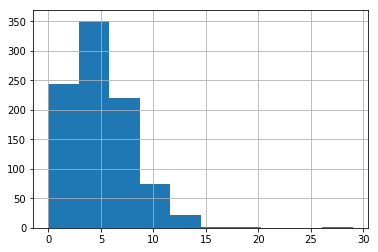

In [47]:
scores = statistics["score1"]
scores.hist()

&lt;matplotlib.axes._subplots.AxesSubplot at 0x1cd8d7d7ac8&gt;

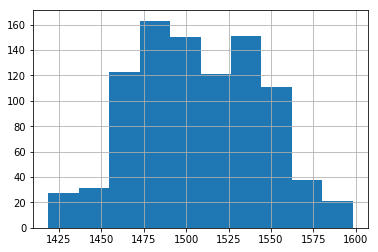

In [48]:
elos = statistics["elo1_pre"]
elos.hist()

&lt;matplotlib.axes._subplots.AxesSubplot at 0x1cd8d8d9358&gt;

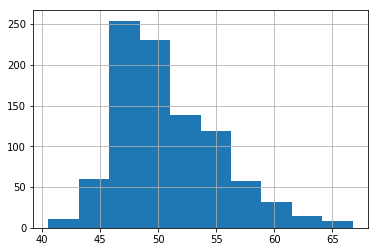

In [77]:
pitchers = statistics["pitcher1_rgs"]
pitchers.hist()

Thinking about predictors. 

Like I said in the previous section, we only want to be looking at data that we have prior to the game. Of that data, what are the things that we care about for predicting the score of team 1. Well, we care about the elo of both teams, the rating of both teams, and the rolling game score of the pitcher that the team is facing. This should give us most fo the information necessary to predict the outcome of a game.

In [40]:
statistics.columns

Index([&#39;date&#39;, &#39;season&#39;, &#39;neutral&#39;, &#39;playoff&#39;, &#39;team1&#39;, &#39;team2&#39;, &#39;elo1_pre&#39;,
       &#39;elo2_pre&#39;, &#39;elo_prob1&#39;, &#39;elo_prob2&#39;, &#39;elo1_post&#39;, &#39;elo2_post&#39;,
       &#39;rating1_pre&#39;, &#39;rating2_pre&#39;, &#39;pitcher1&#39;, &#39;pitcher2&#39;, &#39;pitcher1_rgs&#39;,
       &#39;pitcher2_rgs&#39;, &#39;pitcher1_adj&#39;, &#39;pitcher2_adj&#39;, &#39;rating_prob1&#39;,
       &#39;rating_prob2&#39;, &#39;rating1_post&#39;, &#39;rating2_post&#39;, &#39;score1&#39;, &#39;score2&#39;],
      dtype=&#39;object&#39;)

In [41]:
relevant = statistics
relevant = relevant[["elo1_pre",'elo2_pre','pitcher2_rgs', 'pitcher1_rgs','rating1_pre','rating2_pre','score1','score2']]
relevant = relevant.dropna()
Y_1 = relevant[["score1"]]
Y_2 = relevant[["score2"]]
X_1 = relevant[["elo1_pre","elo2_pre","pitcher2_rgs"]]
X_2 = relevant[["elo1_pre","elo2_pre","pitcher1_rgs"]]

Running linear regression here. We talked abouta pitfall of linear regression in class being that there is an issue when the data is correlated. There is correlation here among the predictors, but I'm not exactly sure how to remove it. The ratings and elo are likely highly correlated. There is also some correlation between the pitcher rgs and the elo, as well as very small negative correlations between the teams ratings/elos. 

In [105]:
reg = linear_model.LinearRegression()
reg.fit(X_1,Y_1)
team1_coef = reg.coef_

reg2 = linear_model.LinearRegression()
reg2.fit(X_2,Y_2)
team2_coef = reg2.coef_
print(team1_coef,team2_coef)

[[ 0.00280443 -0.00188058 -0.09768908]] [[-0.00773806  0.00455171 -0.09059969]]


As a sanity check, the signs of all of the coefficients above make sense. We would expect team 1 to score mroe runs when they have a higher elo, fewer runs when team 2 has a high elo, and fewer runs when pitcher2 has a high rgs.  

Making a prediction here. We are going to predict the score of the september 27 game between the Royals and the Lions this year which was the last game of the season. The relevant data from this row will be the elos and pitcher rgs from each team. This gives us a predicted score of 2.8999 for the royals and a predicted score of 9.48 for detroit. If we had to make predictions on integer values here then we would guess that the royals score 3 runs and lose by 6 to the lions. The royals did in fact score 3 runs this game, but they beat the lions by two.

In [106]:
kc = statistics[statistics["team1"] == "KCR"]
kc = kc[kc["date"] == "2020-09-27"]

# elo
kc_pred_score = team1_coef[0][0] * kc.iloc[0]["elo1_pre"] + team1_coef[0][1] * kc.iloc[0]["elo2_pre"] +  team1_coef[0][2] * kc.iloc[0]["pitcher2_rgs"]
det_pred_score = team2_coef[0][0] * kc.iloc[0]["elo1_pre"] + team2_coef[0][1] * kc.iloc[0]["elo2_pre"] +  team2_coef[0][2] * kc.iloc[0]["pitcher1_rgs"]
print(abs(kc_pred_score), abs(det_pred_score))

2.8999981906453214 9.488979413892064


Here we are doing the same thing except we use the GradientBoostRegressor instead of simple linear regression. This is a more sophisticated model that shuold be more accurate on average. As discussed in class, gradient boosting takes multiple weak learners and combines them into a strong learner. This takes longer because it takes the successes results and uses that to run the next learner. This is not too bad here though because we don't have too many data points. When we use Gradient Boosting we get that the Royals score 4 and the Lions score 5

In [107]:
regressor = GradientBoostingRegressor(random_state=0)
regressor.fit(X_1, Y_1)
kc_score = regressor.predict([[kc.iloc[0]["elo1_pre"],kc.iloc[0]["elo2_pre"],kc.iloc[0]["pitcher1_rgs"]]])

In [108]:
regressor2 = GradientBoostingRegressor(random_state=0)
regressor2.fit(X_1, Y_1)
det_score = regressor2.predict([[kc.iloc[0]["elo1_pre"],kc.iloc[0]["elo2_pre"],kc.iloc[0]["pitcher2_rgs"]]])

In [109]:
print(kc_score,det_score)

[3.592282] [5.14928318]
